In [127]:
#@title dnn_app_utils_v2
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [128]:
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache


In [129]:
def relu(Z):
    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)

    cache = Z
    return A, cache



In [130]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ


In [131]:
def sigmoid_backward(dA, cache):

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ


In [132]:
import urllib
from pathlib import Path
def download_data():
  train = 'https://github.com/csaybar/DLcoursera/raw/master/Neural%20Networks%20and%20Deep%20Learning/week2/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/train_catvnoncat.h5'
  test = 'https://github.com/csaybar/DLcoursera/raw/master/Neural%20Networks%20and%20Deep%20Learning/week2/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/test_catvnoncat.h5'
  urllib.request.urlretrieve(train,'train_catvnoncat.h5')
  urllib.request.urlretrieve(test,'test_catvnoncat.h5')

filetrain= Path("test_catvnoncat.h5")
filetest = Path("train_catvnoncat.h5")
if filetrain.is_file() and filetest.is_file():
  print("File Sudah Ada")
else:
  download_data()

File Sudah Ada


In [133]:
def load_data():

    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [134]:
def initialize_parameters(n_x, n_h, n_y):

    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [97]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))


    return parameters

In [98]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

In [99]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [100]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

In [101]:
def compute_cost(AL, Y):

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())

    return cost

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

In [102]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [103]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [104]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [105]:
def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    #print ("Hidden Layer: " + str(n_h))
    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p

In [106]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [107]:
#@title dnn_app_utils_v3

import numpy as np
import matplotlib.pyplot as plt
import h5py


def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def relu(Z):

    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)

    cache = Z
    return A, cache


def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ


def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters(n_x, n_h, n_y):

    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


def initialize_parameters_deep(layer_dims):

    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))


    return parameters

def linear_forward(A, W, b):

    Z = W.dot(A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

def compute_cost(AL, Y):

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())

    return cost

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p

def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


In [85]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Dataset


**Problem Statement**: You are given a dataset "Cat vs non-Cat" dataset ("data.h5") containing:

    - a training set of m_train images labelled as cat (1) or non-cat (0)

    - a test set of m_test images labelled as cat and non-cat
    
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [86]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images.

y = 0. It's a non-cat picture.


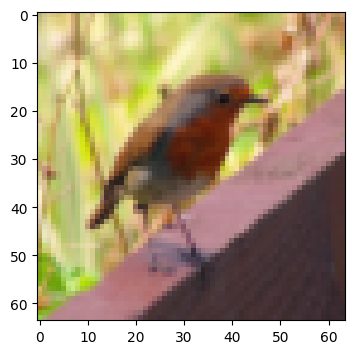

In [ ]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [24]:
# Explore your dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="https://github.com/csaybar/DLcoursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/week4/Deep%20Neural%20Network%20Application%20Image%20Classification/images/imvectorkiank.png?raw=1" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

Data Preprocessing

In [25]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$.

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="https://github.com/csaybar/DLcoursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/week4/Deep%20Neural%20Network%20Application%20Image%20Classification/images/2layerNN_kiank.png?raw=1" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$.
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias).
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="https://github.com/csaybar/DLcoursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/week4/Deep%20Neural%20Network%20Application%20Image%20Classification/images/LlayerNN_kiank.png?raw=1" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop)
    4. Use trained parameters to predict labels

Let's now implement those two models!

## 4 - Two-layer neural network

Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:


In [26]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [27]:

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0001, num_iterations = 1000, print_cost=False):

    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    

    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        cost = compute_cost(A2, Y)
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6924675743269387
Cost after iteration 200: 0.6918956508701695
Cost after iteration 300: 0.6913426885166042
Cost after iteration 400: 0.6908020620142727
Cost after iteration 500: 0.6902471865347105
Cost after iteration 600: 0.6896748478418517
Cost after iteration 700: 0.6890802167922934
Cost after iteration 800: 0.6884605474223713
Cost after iteration 900: 0.6878067630499123


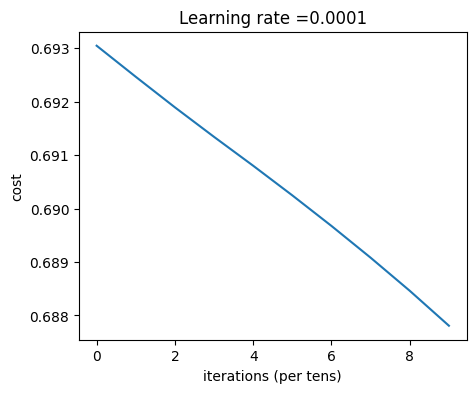

In [28]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 1000, print_cost=True)

In [29]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [30]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001


In [31]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [32]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009


    np.random.seed(1)
    costs = [] 
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


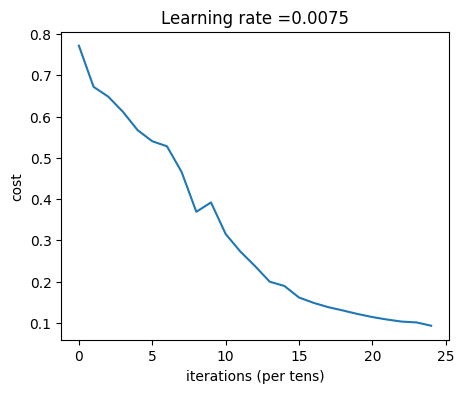

In [33]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [34]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [35]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


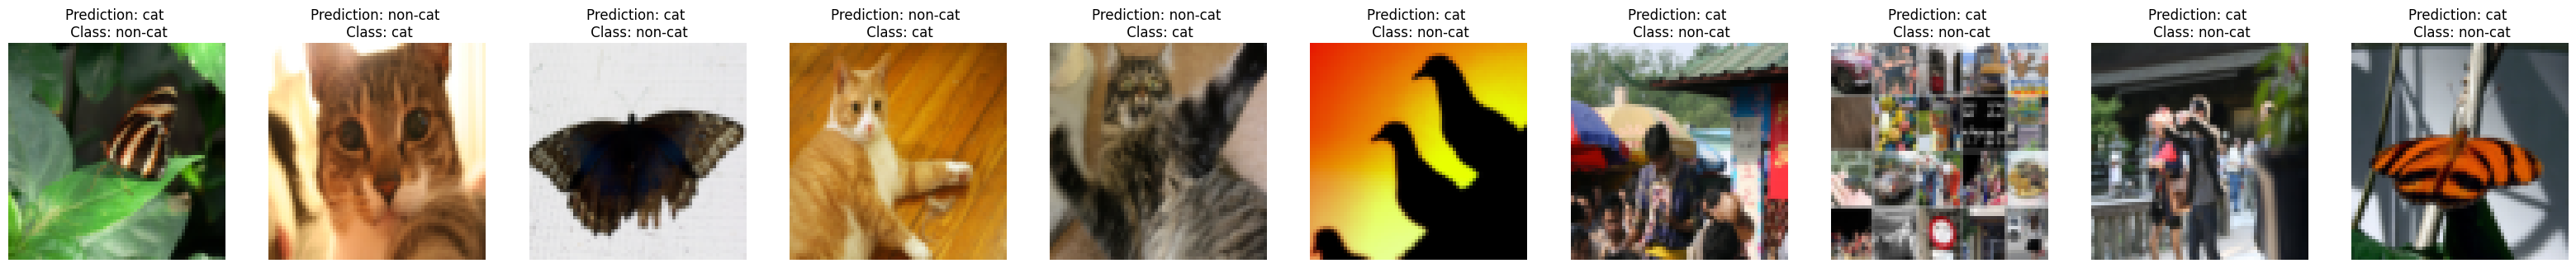

In [36]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:**
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image)

### **QUESTION 2** ####
Jika diinputkan learning_rate = 0.0001 dan num_iteration = 1000:

1. Bagaimana pengaruh jumlah neuron pada hidden layer? (TASK 1)
2. Bagaimana pengaruh jumlah learning_rate dan num_iterations terhadap cost function dan akurasi? (TASK 2&3)
3. Gunakanlah hyperparameter optimization random/grid search untuk mendapatkan learning_rate dan num_iteration optimal yang menghasilkan akurasi terbaik!

In [37]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

In [38]:
# Menghasilkan data untuk eksperimen
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [39]:
# Fungsi untuk membuat model neural network
def create_model(num_neurons=32, learning_rate=0.0001):
    model = Sequential([
        Dense(num_neurons, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [40]:
# TASK 1: Pengaruh Jumlah Neuron di Hidden Layer
def task_1_neurons_effect(num_neurons_list, learning_rate=0.0001, num_iterations=1000):
    for num_neurons in num_neurons_list:
        print(f"Testing with {num_neurons} neurons in hidden layer.")
        model = create_model(num_neurons=num_neurons, learning_rate=learning_rate)
        model.fit(X_train, y_train, epochs=num_iterations, verbose=0)
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Accuracy with {num_neurons} neurons: {accuracy:.4f}")

In [41]:
# Menjalankan TASK 1
num_neurons_list = [8, 16, 32, 64, 128]
task_1_neurons_effect(num_neurons_list)

Testing with 8 neurons in hidden layer.
Accuracy with 8 neurons: 0.8600
Testing with 16 neurons in hidden layer.
Accuracy with 16 neurons: 0.8600
Testing with 32 neurons in hidden layer.
Accuracy with 32 neurons: 0.8350
Testing with 64 neurons in hidden layer.
Accuracy with 64 neurons: 0.8450
Testing with 128 neurons in hidden layer.
Accuracy with 128 neurons: 0.8200


In [42]:
# TASK 2: Pengaruh learning_rate dan num_iterations
def task_2_learning_rate_iterations_effect(learning_rate_list, iteration_list):
    for lr in learning_rate_list:
        for iterations in iteration_list:
            print(f"\nTesting with learning_rate={lr} and num_iterations={iterations}")
            model = create_model(learning_rate=lr)
            model.fit(X_train, y_train, epochs=iterations, verbose=0)
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f"Accuracy with learning_rate={lr}, iterations={iterations}: {accuracy:.4f}")

In [43]:
# Menjalankan TASK 2
learning_rate_list = [0.0001]
iteration_list = [1000]
task_2_learning_rate_iterations_effect(learning_rate_list, iteration_list)


Testing with learning_rate=0.0001 and num_iterations=1000
Accuracy with learning_rate=0.0001, iterations=1000: 0.8300


In [44]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform
import numpy as np
from sklearn.metrics import accuracy_score

In [45]:
# Fungsi untuk membangun model
def create_model(learning_rate=0.0001, neurons=16):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [46]:
# Definisikan KerasClassifier untuk digunakan dalam GridSearchCV/RandomizedSearchCV
keras_model = KerasClassifier(build_fn=create_model, verbose=0)

C:\Users\ccoos\AppData\Local\Temp\ipykernel_20968\2343240021.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=create_model, verbose=0)


In [47]:
param_grid = {
    'neurons': [8, 16],
    'learning_rate': [0.0001],
    'epochs': [500, 1000],
}

In [48]:
from tensorflow.keras.callbacks import Callback

# Define a custom callback to print each epoch
class EpochPrintCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}: Loss = {logs["loss"]:.4f}, Accuracy = {logs["accuracy"]:.4f}')

def build_model(learning_rate=0.001, neurons=64, epochs=1000):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer with learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Use the custom callback to print each epoch
    model.fit(X_train, y_train, epochs=epochs, verbose=0, batch_size=32, callbacks=[EpochPrintCallback()])

    return model


In [49]:
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, n_jobs=1, verbose=3)
grid_search.fit(X_train, y_train)

print(f"Optimal Hyperparameters (Grid Search): {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END epochs=500, learning_rate=0.0001, neurons=8;, score=0.865 total time=  28.5s
[CV 2/3] END epochs=500, learning_rate=0.0001, neurons=8;, score=0.858 total time=  28.4s
[CV 3/3] END epochs=500, learning_rate=0.0001, neurons=8;, score=0.850 total time=  28.3s
[CV 1/3] END epochs=500, learning_rate=0.0001, neurons=16;, score=0.865 total time=  30.6s
[CV 2/3] END epochs=500, learning_rate=0.0001, neurons=16;, score=0.854 total time=  31.1s
[CV 3/3] END epochs=500, learning_rate=0.0001, neurons=16;, score=0.850 total time=  29.2s
[CV 1/3] END epochs=1000, learning_rate=0.0001, neurons=8;, score=0.861 total time= 1.1min
[CV 2/3] END epochs=1000, learning_rate=0.0001, neurons=8;, score=0.861 total time= 1.1min
[CV 3/3] END epochs=1000, learning_rate=0.0001, neurons=8;, score=0.876 total time= 1.1min
[CV 1/3] END epochs=1000, learning_rate=0.0001, neurons=16;, score=0.854 total time= 1.4min
[CV 2/3] END epochs=1000, learni

In [50]:
# Menampilkan parameter terbaik yang ditemukan oleh GridSearchCV
print("Optimal Hyperparameters (Grid Search):")
print(grid_search.best_params_)
print(f"Best accuracy: {grid_search.best_score_:.4f}")

Optimal Hyperparameters (Grid Search):
{'epochs': 1000, 'learning_rate': 0.0001, 'neurons': 8}
Best accuracy: 0.8663


In [51]:
# Wrapper to enable verbose training with the callback inside the RandomizedSearch
def model_builder(learning_rate=0.001, neurons=64, epochs=1000):
    model = build_model(learning_rate=learning_rate, neurons=neurons)
    model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=32, 
        verbose=0, 
        callbacks=[EpochPrintCallback()]  # custom callback for printing
    )
    return model

In [52]:
param_distributions = {
    'learning_rate': [0.0001],
    'neurons': [8, 16],
    'epochs': [500, 1000],
}

In [53]:
keras_model = KerasClassifier(model_builder, verbose=0)
random_search = RandomizedSearchCV(estimator=keras_model, param_distributions=param_distributions, cv=3, n_iter=10, n_jobs=1, verbose=3)
random_search.fit(X_train, y_train)

C:\Users\ccoos\AppData\Local\Temp\ipykernel_20968\1292761058.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(model_builder, verbose=0)
c:\Users\ccoos\.conda\envs\python3.9\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1: Loss = 0.7881, Accuracy = 0.5400
Epoch 2: Loss = 0.7813, Accuracy = 0.5425
Epoch 3: Loss = 0.7745, Accuracy = 0.5462
Epoch 4: Loss = 0.7680, Accuracy = 0.5525
Epoch 5: Loss = 0.7615, Accuracy = 0.5575
Epoch 6: Loss = 0.7549, Accuracy = 0.5638
Epoch 7: Loss = 0.7487, Accuracy = 0.5663
Epoch 8: Loss = 0.7425, Accuracy = 0.5700
Epoch 9: Loss = 0.7365, Accuracy = 0.5725
Epoch 10: Loss = 0.7305, Accuracy = 0.5763
Epoch 11: Loss = 0.7247, Accuracy = 0.5800
Epoch 12: Loss = 0.7190, Accuracy = 0.5850
Epoch 13: Loss = 0.7133, Accuracy = 0.5888
Epoch 14: Loss = 0.7078, Accuracy = 0.5925
Epoch 15: Loss = 0.7023, Accuracy = 0.5975
Epoch 16: Loss = 0.6971, Accuracy = 0.5987
Epoch 17: Loss = 0.6918, Accuracy = 0.6000
Epoch 18: Loss = 0.6867, Accuracy = 0.6025
Epoch 19: Loss = 0.6816, Accuracy = 0.6025
Epoch 20: Loss = 0.6766, Accuracy = 0.6062
Epoch 21: Loss = 0.6718, Accuracy = 0.6075
Epoch 22: Loss = 0.6669, Accuracy = 0.6137
Epo

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000015E8005BBE0>,
                   n_jobs=1,
                   param_distributions={'epochs': [500, 1000],
                                        'learning_rate': [0.0001],
                                        'neurons': [8, 16]},
                   verbose=3)

In [54]:
# Menampilkan parameter terbaik yang ditemukan oleh RandomizedSearchCV
print("\nOptimal Hyperparameters (Randomized Search):")
print(random_search.best_params_)
print(f"Best accuracy: {random_search.best_score_:.4f}")


Optimal Hyperparameters (Randomized Search):
{'neurons': 16, 'learning_rate': 0.0001, 'epochs': 500}
Best accuracy: 0.9000


In [55]:
# Evaluasi model terbaik pada data uji
best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
print(f"Test Accuracy of Best Model (Grid Search): {accuracy_grid:.4f}")

7/7 [==============================] - 0s 2ms/step
Test Accuracy of Best Model (Grid Search): 0.8550


In [56]:
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)
accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"Test Accuracy of Best Model (Randomized Search): {accuracy_random:.4f}")


7/7 [==============================] - 0s 2ms/step
Test Accuracy of Best Model (Randomized Search): 0.8300


### **QUESTION 3** ####
Jika diinputkan learning_rate = 0.0001 dan num_iteration = 1000:

1. Bagaimana pengaruh jumlah neuron pada hidden layer?(TASK 4)
2. Bagaimana pengaruh jumlah learning_rate dan num_iterations bagian terhadap cost function dan akurasi? (TASK 5&6)
3. Gunakanlah hyperparameter optimization random/grid search untuk mendapatkan learning_rate dan num_iteration optimal yang menghasilkan akurasi terbaik, tampilkan output akurasinya!


### **QUESTION 4** ###
1. Bagaimana perbandingan output antara Two-layer NN dengan L-layer NN?
2. Bagaimana pengaruh jumlah hidden layer (L) pada Neural Network dalam performansi(akurasi) dan computing time? apa yang terjadi jika L semakin besar?

# 7) Testing

In [57]:
import numpy as np
import imageio
from PIL import Image
import matplotlib.pyplot as plt

y = 1, your L-layer model predicts a "cat" picture.


C:\Users\ccoos\AppData\Local\Temp\ipykernel_20968\2167423550.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fname)  # Using imageio to read the image


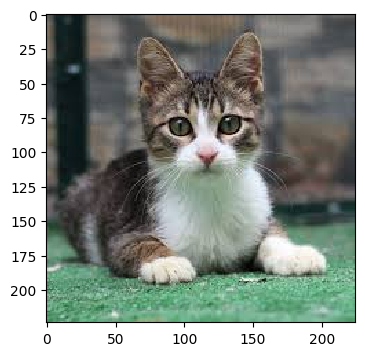

In [165]:
## START CODE HERE ##
my_image = "my_image.jpg"  # Change this to the name of your image file
my_label_y = [1]  # The true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = my_image
image = imageio.imread(fname)  # Using imageio to read the image
image_resized = Image.fromarray(image).resize((num_px, num_px))  # Resize using PIL
my_image = np.array(image_resized).reshape((num_px * num_px * 3, 1)) / 255.  # Normalize
# Prediction
my_predicted_image = predict(my_image, my_label_y, parameters)

# Display the image and prediction
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")


y = 0, your L-layer model predicts a "non-cat" picture.


C:\Users\ccoos\AppData\Local\Temp\ipykernel_20968\35183236.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fname)  # Using imageio to read the image


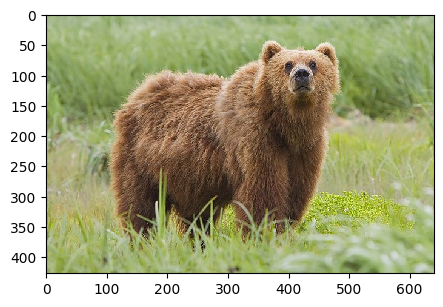

In [170]:
## START CODE HERE ##
my_image = "bear.jpg"  # Change this to the name of your image file
my_label_y = [1]  # The true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = my_image
image = imageio.imread(fname)  # Using imageio to read the image
image_resized = Image.fromarray(image).resize((num_px, num_px))  # Resize using PIL
my_image = np.array(image_resized).reshape((num_px * num_px * 3, 1)) / 255.  # Normalize
# Prediction
my_predicted_image = predict(my_image, my_label_y, parameters)

# Display the image and prediction
plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")


In [184]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import imageio
import matplotlib.pyplot as plt


num_px = 64  # contoh ukuran untuk resize, sesuaikan dengan model Anda
classes = np.array([b"non-cat", b"cat"])  # asumsi 0 -> non-cat, 1 -> cat

# Contoh dummy parameters, ganti dengan parameters sebenarnya
parameters = {
    "W1": None,
    "b1": None,
    "W2": None,
    "b2": None
}

# Contoh dummy fungsi predict, ganti dengan fungsi sebenarnya
def predict(X, y, parameters):

    pred = np.random.randint(0, 2, size=(1,1))  # 0 atau 1 acak
    return pred

class CatDetectorApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Cat Detector")

        # Frame untuk tombol dan label
        self.frame = tk.Frame(self.master)
        self.frame.pack(padx=10, pady=10)

        # Tombol pilih gambar
        self.btn_select_image = tk.Button(
            self.frame, text="Pilih Gambar", command=self.open_image_dialog
        )
        self.btn_select_image.grid(row=0, column=0, padx=5, pady=5)

        # Label untuk menampilkan gambar
        self.image_label = tk.Label(self.frame, text="Belum ada gambar")
        self.image_label.grid(row=1, column=0, padx=5, pady=5)

        # Label untuk menampilkan hasil prediksi
        self.result_label = tk.Label(self.frame, text="")
        self.result_label.grid(row=2, column=0, padx=5, pady=5)

    def open_image_dialog(self):
        """
        Fungsi untuk membuka dialog file,
        lalu memuat gambar, melakukan prediksi,
        dan menampilkan hasilnya.
        """
        file_path = filedialog.askopenfilename(
            title="Pilih gambar",
            filetypes=[("Image files", "*.jpg *.png *.jpeg *.bmp *.gif")]
        )
        if file_path:
            # Membaca gambar
            image = imageio.imread(file_path)
            # Resize gambar
            image_resized = Image.fromarray(image).resize((num_px, num_px))
            
            # Konversi jadi array (num_px * num_px * 3, 1) dan normalisasi
            my_image = np.array(image_resized).reshape((num_px*num_px*3, 1)) / 255.

            # Contoh label_y (tidak selalu diperlukan, tergantung implementasi predict)
            my_label_y = [1]  # misal 1 berarti 'cat' sebagai true label

            # Melakukan prediksi
            my_predicted_image = predict(my_image, my_label_y, parameters)
            
            # Menampilkan gambar di label
            # (Agar bisa ditampilkan di Tkinter, perlu konversi ke ImageTk)
            pil_image = Image.fromarray(image)
            tk_image = ImageTk.PhotoImage(pil_image)
            self.image_label.configure(image=tk_image)
            self.image_label.image = tk_image  # Simpan referensi agar tidak di-GC

            # Menampilkan hasil prediksi di label
            pred_class = int(np.squeeze(my_predicted_image))
            pred_text = classes[pred_class].decode("utf-8")
            
            if pred_class == 0:
                self.result_label.config(
                    text=f"Model memprediksi ini adalah: {pred_text} (Bukan kucing)",
                    fg="red"
                )
            else:
                self.result_label.config(
                    text=f"Model memprediksi ini adalah: {pred_text} (Kucing)",
                    fg="green"
                )

            # plt.imshow(image)
            # plt.title(f"Prediksi: {pred_text}")
            # plt.show()


if __name__ == "__main__":
    root = tk.Tk()
    app = CatDetectorApp(root)
    root.mainloop()


C:\Users\ccoos\AppData\Local\Temp\ipykernel_20968\2732368510.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_path)
